In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090b_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 1: Clustering & Hierarchical Bayesian Models



**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas & Natesh Pillai


<hr style="height:2pt">

In [3]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

## Notebook Contents
<a id="contents"></a>
- [**Part 0: K-means Clustering of Animal Traits**](#part0)
- **Bayesian Logistic Regression**
- [**Part 1: Varying-Intercept Model (Simulated Response Variable)**](#part1)
- [**Part 2: Varying-Intercept Model (Real Data)**](#part2)
- [**Part 3: Varying-Coefficients Model**](#part3)
- [**Part 4: Prediction & Model Selection**](#part4)

In [4]:
# Imports for Part 0
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# You can decide what to import from the preprocessing module
#from sklearn.preprocessing import ...

In [5]:
# measure notebook runtime
time_start = time.time()

<a id="part0"></a>

### <div class='exercise'>Part 0: K-means Clustering of Animal Traits</div> 
As a warm-up, we'll perform K-means clustering on a dataset of animal characteristics before moving on to our main Bayesian analysis.

[Return to contents](#contents)

<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.1 - Data Preprocessing</b></div>

The file `zoo.csv` contains information about 100 different animals.

Load the data into a Pandas DataFrame and inspect the features. You will need to decide which columns it makes sense to include as input to the K-means clustering algorithm and what preprocessing you deem necessary. Store the processed features in a matrix `X`.

**Note:** You must justify your preprocessing decisions based on the nature of the features and your clustering objectives. This also applies to *negative* decisions (e.g., choices to *not* perform a generally standard type of preprocessing). 

In [12]:
# your code here

df = pd.read_csv('data/zoo.csv')

df.head()




,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [13]:
from sklearn.preprocessing import StandardScaler

df_copy = df.copy()

df_cleaned = df_copy.drop(columns=['animal_name', 'class_type'])

scaler = StandardScaler()
df_cleaned['legs'] = scaler.fit_transform(df_cleaned[['legs']])

X = df_cleaned.values

*Your answer here*

Answer and Reasoning: Here I have dropped animal_name because it is not numerical, and class_type because it is not physical features. I have normalized legs because all other data are 0, 1. 

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q0.2 - PCA Visualization</b></div>
Before we begin clustering, we should attempt to visualize the data.

Create a 2D scatter plot of the data projected onto the first two principle components. Be sure to also report the variance explained by these components.

Based on your visualization, discuss whether you see evidence of natural clusters in the data.

**Hint:** There is a PCA projection plot in the penguin example at the end of the lab 1 notebook.

Explained variance: [0.34917921 0.24901864]


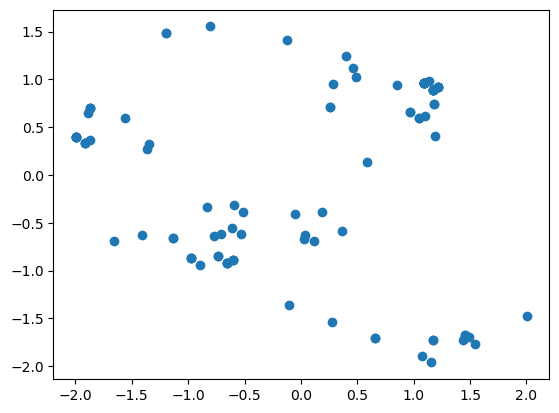

In [15]:
# your code here
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_

plt.scatter(X_pca[:, 0], X_pca[:, 1])

print(f'Explained variance: {explained_variance}')



*Your answer here*


Here we see that a decent amount of variance are explained by the first two principle components. Moreover, there seems to be some clusters on the top right, bottom let, bottom right, and middle left. There seems to be some natural clusters in the data, indicating K-means could be a good choice.



<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.3 - Determining Optimal $k$</b></div>
Implement and visualize two different methods for determining the optimal number of clusters:

1. Plot the inertia vs $k$ for $k \in \{2,3,\dots,20\}$
2. Plot the average silhouette score vs $k$ for the same range

Choose and justify your optimal k based on these metrics. Discuss any differences between what the metrics suggest and whether one seems more reliable for this dataset.

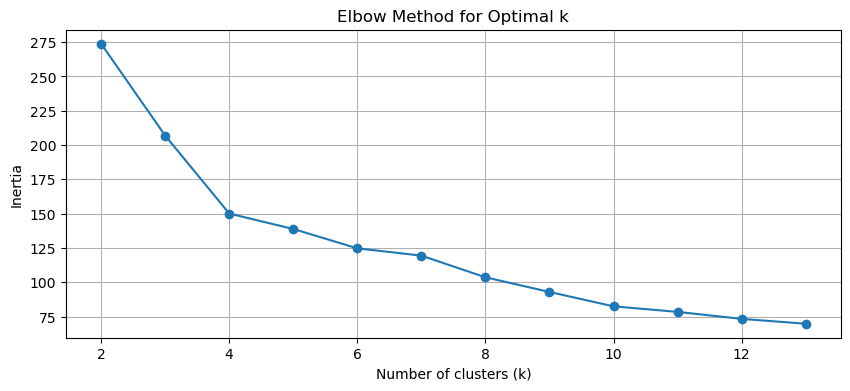

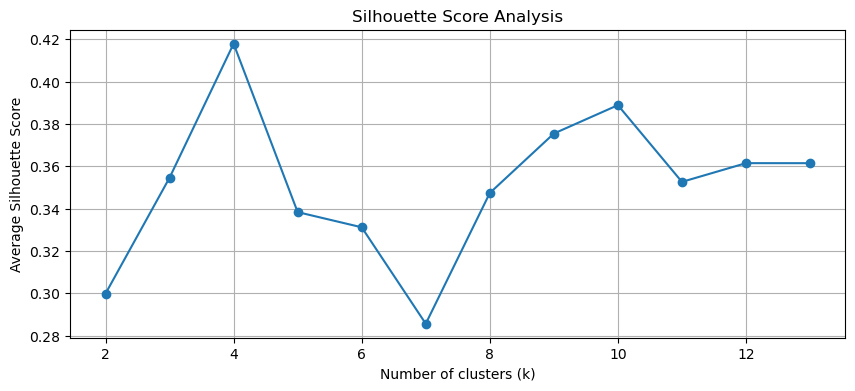

In [21]:
# your code here
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 14)
inertia_values = []
silhouette_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    
    inertia_values.append(kmeans.inertia_)
    silhouette_values.append(silhouette_score(X, kmeans.labels_))

# Plot Inertia vs k
plt.figure(figsize=(10, 4))
plt.plot(k_values, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Plot Silhouette Score vs k
plt.figure(figsize=(10, 4))
plt.plot(k_values, silhouette_values, marker='o', linestyle='-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Score Analysis')
plt.grid(True)
plt.show()


*Your answer here*

Here I would choose K = 10; this is beacuse the inertia plot decreases very marginally as k becomes higher than that, while the Silhouette score is deceasing after 10. The metrics may suggest that at some point the the number of clusters is too many that actually hurts the Silhouette scores.



<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.4 - Cluster Analysis</b></div>

Using the results of fitting K-means with your choice of optimal $k$, create a visualization showing:
   - Your datapoints in the 2D PCA space
   - Points colored by cluster assignment
   - Each `animal_name` annotated on the plot near its corresponding point 

Finally, interpret your results:
   - How well-separated are your clusters?
   - Do the clusters align with biological classifications?
   - Do any points seem to have been assigned to the wrong cluster? You may not be able to tell from your plot alone and so you should investigate this issue using one of the metrics discussed in class.

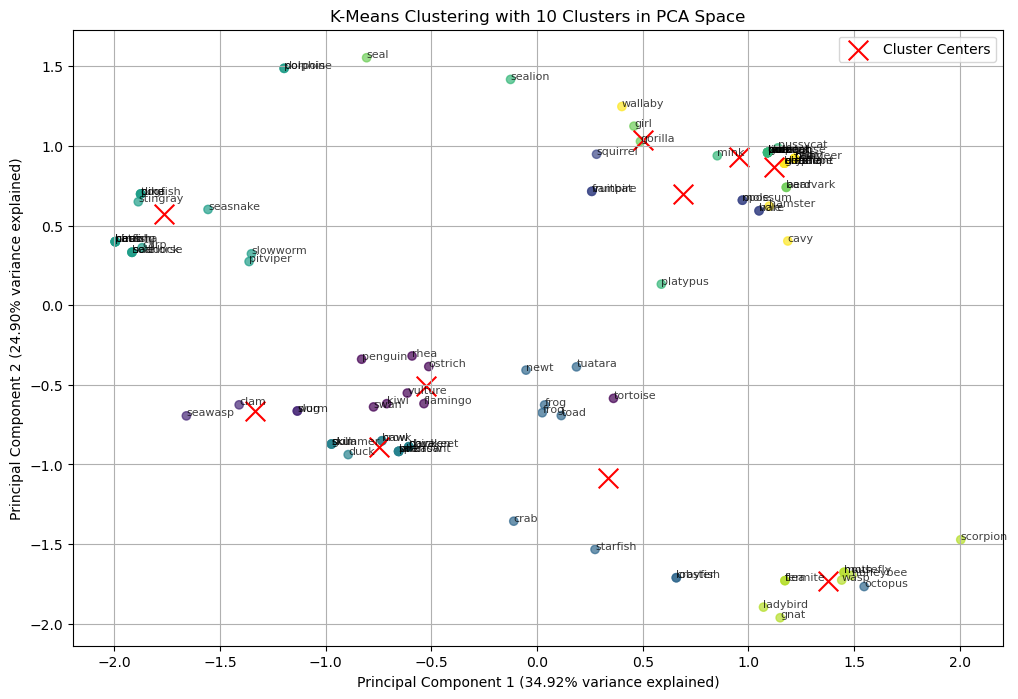

In [22]:
# your code here
kmeans = KMeans(n_clusters=10, init='random', random_state=42)
kmeans.fit(X)
cluster_labels = kmeans.fit_predict(X)

# Create PCA scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)

# Annotate each point with its corresponding animal name
for i, animal in enumerate(df['animal_name']):  
    plt.annotate(animal, (X_pca[i, 0], X_pca[i, 1]), fontsize=8, alpha=0.75)

# Plot cluster centers in PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], marker='x', s=200, c='red', label='Cluster Centers')

plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')
plt.title(f'K-Means Clustering with {10} Clusters in PCA Space')
plt.legend()
plt.grid(True)
plt.show()


*Your answer here*

 - How well-separated are your clusters?
   - Do the clusters align with biological classifications?
   - Do any points seem to have been assigned to the wrong cluster? You may not be able to tell from your plot alone and so you should investigate this issue using one of the metrics discussed in class.

1. My clusters are relatively well separated except in the top right.

2. Clusters seem to vaguely correspond to biological classifications

3. Things like slowworm, girl, ladybird seemt to be mis-identified. 


In [6]:
# Additional imports for Parts 1-4
import arviz as az
import pymc as pm
from scipy.special import expit

## Hierarchical Bayesian Models

## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with datasets `train.csv` and `test.csv` which contain details of contraceptive usage among 1,934 Bangladeshi women.

There are four attributes for each woman along with a response variable, `contraceptive_use`, indicating if she uses contraceptives. The four attributes include:

* `district`: code identifying the district in which the woman lives (60 districts in total)
* `urban`: type of region of residence (binary)
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The task is to build a classification model that can predict if a given woman uses contraceptives.

The following cell will load and inspect the train and test datasets.

TRAINING DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 37.9 KB

TEST DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
m

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1


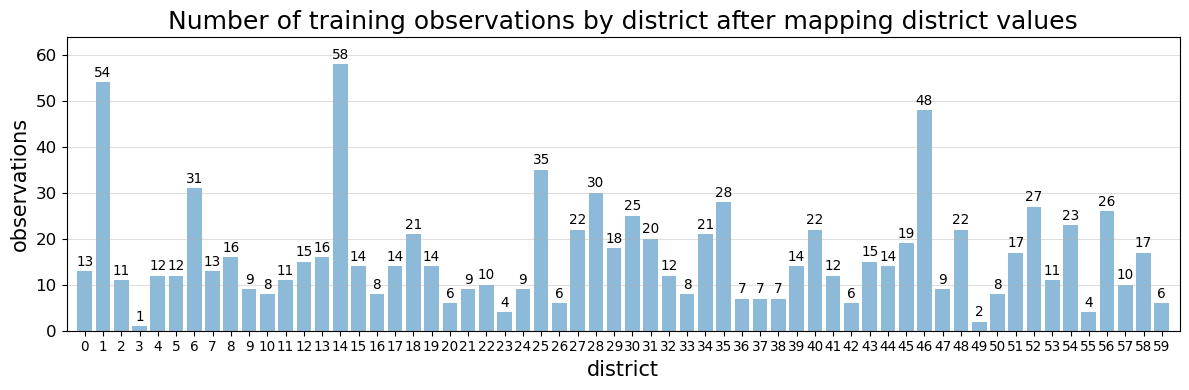

In [7]:
# loading and inspecting the data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# print dataset summary info for ease of reference
print("TRAINING DATA INFO:\n")
df_train.info()
print("\nTEST DATA INFO:\n")
df_test.info()
print("\nTRAINING DATA SUMMARY STATS:\n")
print(df_train.describe())
print("\nTRAINING DATA FIRST ROWS OF DATA:")
display(df_train.head(3))
print()

# And plot observation counts by district also just for reference
def plot_value_counts(value_counts, var_name, font_perc):
    """Generates barplot from pandas value_counts series"""
    fig, ax = plt.subplots(figsize=(12, 4))

    max_y = max(value_counts.values)
    n_cats = len(value_counts)

    ax.bar(range(n_cats), value_counts.values, alpha=0.5)

    for x, y in enumerate(value_counts):
        ax.text(
            x, y+max_y*.02,
            "{:,}".format(y),
            color="k",
            fontsize=14*font_perc,
            horizontalalignment="center"
        ) 

    ax.set_title(
        "Number of training observations by {} after mapping district values".format(
            var_name
        ),
        fontsize=18
    )
    ax.set_xlabel("{}".format(var_name), fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_xticks(range(n_cats))
    ax.set_xticklabels(value_counts.index)
    ax.tick_params("x", labelsize=14*font_perc)
    ax.tick_params("y", labelsize=12)
    ax.set_ylim(top=max_y+(max_y*.1))

    ax.grid(":", axis="y", alpha=0.4)
    ax.margins(x=.01)
    plt.tight_layout()
    plt.show();

# plot and print summary of resulting district values
dist_counts = df_train["district"].value_counts().sort_index()

plot_value_counts(dist_counts, "district", .7)



## Bayesian Logistic Regression with Varying-Intercept Description


The first model we'd like to fit to the contraceptives data will be a **varying-intercept logistic regression** model, where the model's intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part1"></a>

### <div class='exercise'>Part 1: Varying-Intercept Model (Simulated Response Variable)</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1 - Simulate Response</b></div>

To verify that PyMC can indeed recover the hidden parameter values, we'll simulate values of the response variable, `contraceptive_use`, for observations in the training set using the 4 predictors and *hard-coded model parameters of our choosing*. Then, using this simulated data, we'll check if PyMC can get back the parameter values that we hard-coded. If it does, we'll have some reason to believe that it can recover the hidden parameter values that generated the *real* data.

**Note: Synthetic response values generated using the parameters below will only be used in question 1.1 - 1.4**.

Generate $Y$ using the training data and the following hard-coded values:

$$
\begin{split}
\mu_0 &= 0.5
\\ \\
\sigma^2_0 &= 0.3
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 1
\\ \\ 
\beta_2 &= -0.5
\\ \\
\beta_3 &= -0.3
\\ \\
\end{split}
$$

Save your simulated values in a numpy array called `simulated_Y`.

**Verify that these parameters generate data in which an average of 48% to 50% of subjects use contraceptives.**

In [57]:
# set seed for consistency across runs
np.random.seed(109)
# your code here
...

# mu_0 = np.random.normal(0, 10000)
# sigma_0 = 1/(np.random.gamma(0.1, 0.1))
# beta_0j = np.random.normal(mu_0, sigma_0, 60)
# beta_1 = np.random.normal(0, 10000)
# beta_2 = np.random.normal(0, 10000)
# beta_3 = np.random.normal(0, 10000)
mu_0 = 0.5
sigma_0 = np.sqrt(0.3)  # Convert variance to standard deviation
beta_1 = 1
beta_2 = -0.5
beta_3 = -0.3

beta_0j_dict = {district: np.random.normal(mu_0, sigma_0) for district in range(60)}


# Compute logit probabilities for each observation
logit_p = np.array([
    beta_0j_dict[district] + beta_1 * urban + beta_2 * living_children + beta_3 * age_mean
    for district, urban, living_children, age_mean in zip(
        df_train["district"], df_train["urban"], df_train["living.children"], df_train["age_mean"]
    )
])

# Convert logit to probability
p = 1 / (1 + np.exp(-logit_p))

# Simulate contraceptive use based on Bernoulli trial
simulated_Y = np.random.binomial(1, p)

# Verify proportion of contraceptive use
contraceptive_use_rate = simulated_Y.mean()
print(f"Simulated contraceptive use rate: {contraceptive_use_rate:.4f}")

# Ensure the simulated rate falls within 48% to 50%
if 0.48 <= contraceptive_use_rate <= 0.50:
    print("The simulated contraceptive use rate is within the expected range (48%-50%).")
else:
    print("The simulated contraceptive use rate is outside the expected range. Consider adjusting parameters.")

...

Simulated contraceptive use rate: 0.4912
The simulated contraceptive use rate is within the expected range (48%-50%).


Ellipsis

In [58]:
grader.check("q#1.1")

q#1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 - Fit Varying-Intercept Model (Simulated Data)</b></div>

Create and fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested by any warnings from PyMC.

In [62]:
# # your code here
# ...

import numpy as np
import arviz as az
import pymc as pm

# Ensure districts are mapped to integers (0 to 59)
df_train["district"] = df_train["district"].astype(int)

with pm.Model() as varying_intercept_model:
    # Prior for hyperparameters
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100)
    # sigma_0 = np.sqrt(pm.Normal("sigma_0", 1/(pm.Gamma("sigma_0_g", 0.1, 0.1)))) # Check This
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    sigma_0 = pm.Deterministic("sigma_0", 1 / pm.math.sqrt(tau_0))

    # Priors for regression coefficients
    beta_1 = pm.Normal("beta_1", mu=0, sigma=100)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=100)
    beta_3 = pm.Normal("beta_3", mu=0, sigma=100)

    # District-level intercepts
    beta_0j = pm.Normal("beta_0j", mu=mu_0, sigma=sigma_0, shape=60)

    # Linear predictor
    logit_p = (
        beta_0j[df_train["district"].values] +  # Ensure district values are valid indices
        beta_1 * df_train["urban"] +
        beta_2 * df_train["living.children"] +
        beta_3 * df_train["age_mean"]
    )

    # Sigmoid transformation
    p = pm.math.sigmoid(logit_p)

    # Likelihood function (Bernoulli with Binomial form)
    # Y_obs = pm.Binomial("Y_obs", n=1, p=p, observed=df_train["contraceptive_use"])
    Y_obs = pm.Binomial("Y_obs", n=1, p=p, observed=simulated_Y)

    # Sampling
    trace = pm.sample(
        draws=2000,  # Number of posterior samples
        tune=1000,  # Number of tuning samples
        target_accept=0.95,  # Adjust target acceptance to improve convergence
        return_inferencedata=True  # Keep return_inferencedata=True for analysis
    )

# Posterior summary
az.summary(trace)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, beta_1, beta_2, beta_3, beta_0j]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0j[0],0.520,0.566,-0.502,1.610,0.018,0.013,930.0,2722.0,1.01
beta_0j[1],1.460,0.573,0.401,2.572,0.026,0.019,482.0,798.0,1.01
beta_0j[2],0.676,0.594,-0.384,1.857,0.022,0.015,738.0,2580.0,1.01
beta_0j[3],0.568,0.648,-0.634,1.819,0.020,0.014,1073.0,2984.0,1.01
beta_0j[4],0.757,0.572,-0.286,1.865,0.021,0.015,734.0,1947.0,1.01
...,...,...,...,...,...,...,...,...,...
beta_2,-0.485,0.111,-0.704,-0.287,0.006,0.004,334.0,890.0,1.02
beta_3,-0.302,0.025,-0.347,-0.253,0.001,0.001,1169.0,3106.0,1.01
mu_0,0.470,0.351,-0.188,1.147,0.021,0.015,276.0,701.0,1.02
sigma_0,0.533,0.146,0.276,0.807,0.006,0.004,522.0,779.0,1.01


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3 - Convergence Diagnostics</b></div>

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged? Explain your reasoning.


**Hint:** Use the Arviz `plot_trace()` function

/var/folders/kb/h2jmx6m91qld2ldqbdprhbhr0000gn/T/ipykernel_96858/2088451945.py:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing


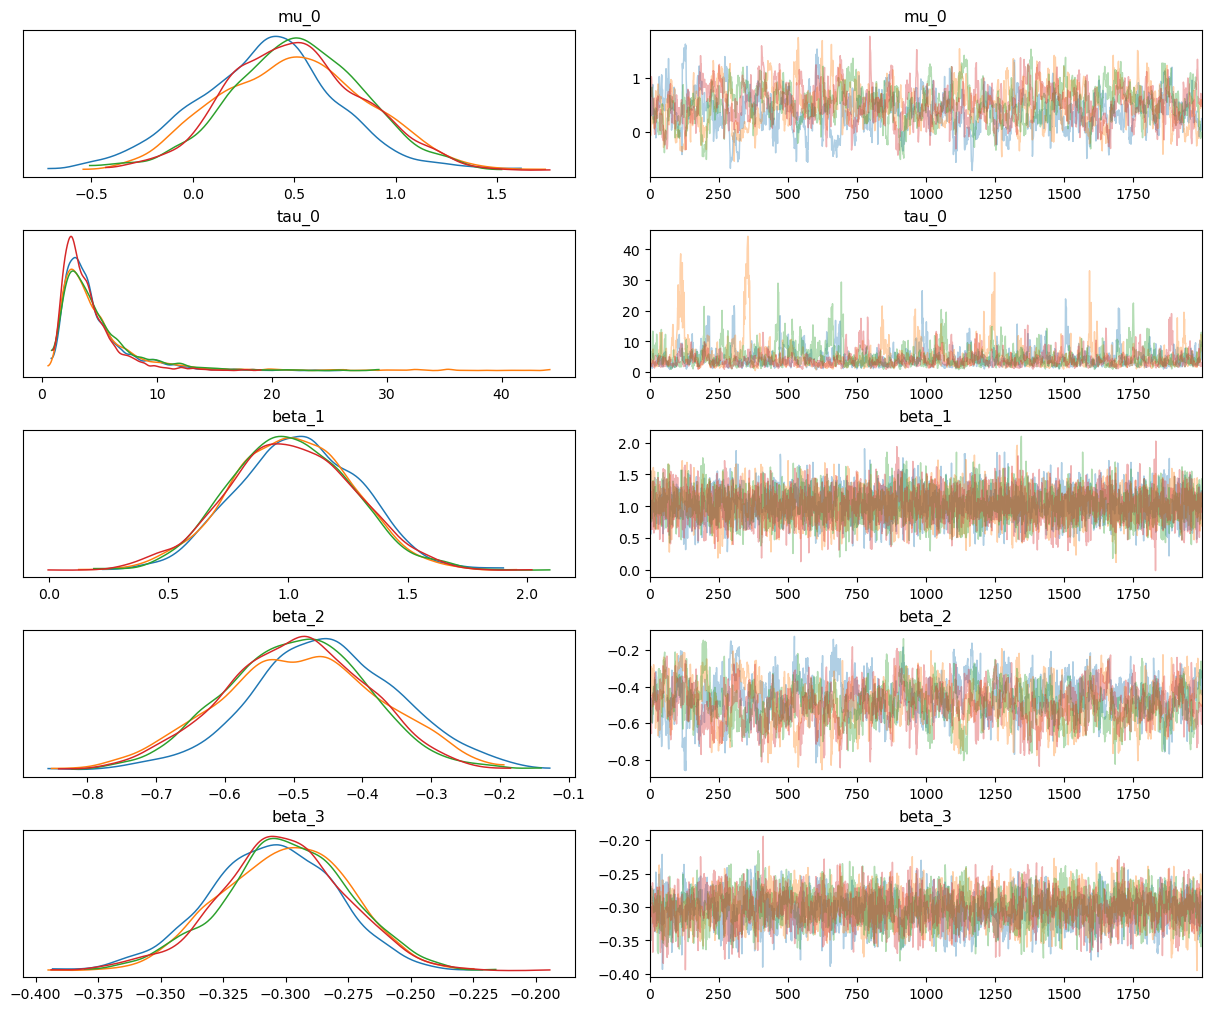

        r_hat
mu_0     1.02
tau_0    1.01
beta_1   1.00
beta_2   1.02
beta_3   1.01


Ellipsis

In [63]:
# your code here

import arviz as az
import matplotlib.pyplot as plt

# Compute τ_0 (precision) from sigma_0
tau_0 = 1 / trace.posterior["sigma_0"]**2
trace.posterior["tau_0"] = tau_0  # Add precision parameter to trace for plotting

# Parameters to plot
params = ["mu_0", "tau_0", "beta_1", "beta_2", "beta_3"]

# Create trace plots with better formatting
fig, axes = plt.subplots(len(params), 2, figsize=(12, 10), constrained_layout=True)

# Generate the trace plots manually for better spacing
az.plot_trace(trace, var_names=params, compact=False, axes=axes)

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing
plt.show()

# Print R-hat values to assess convergence
print(az.summary(trace, var_names=params)[["r_hat"]])



...


*Your answer here*

Based on the trace plots, the chains appear to be well mixed, without any clear trends or drifts over time. The individual chains seem to be overlapping and stationary. Based on the trace plots, the chains appear to be well mixed, without any clear trends or drifts over time. The individual chains seem to be overlapping and stationary.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.4 - Inspecting Posteriors</b></div>

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

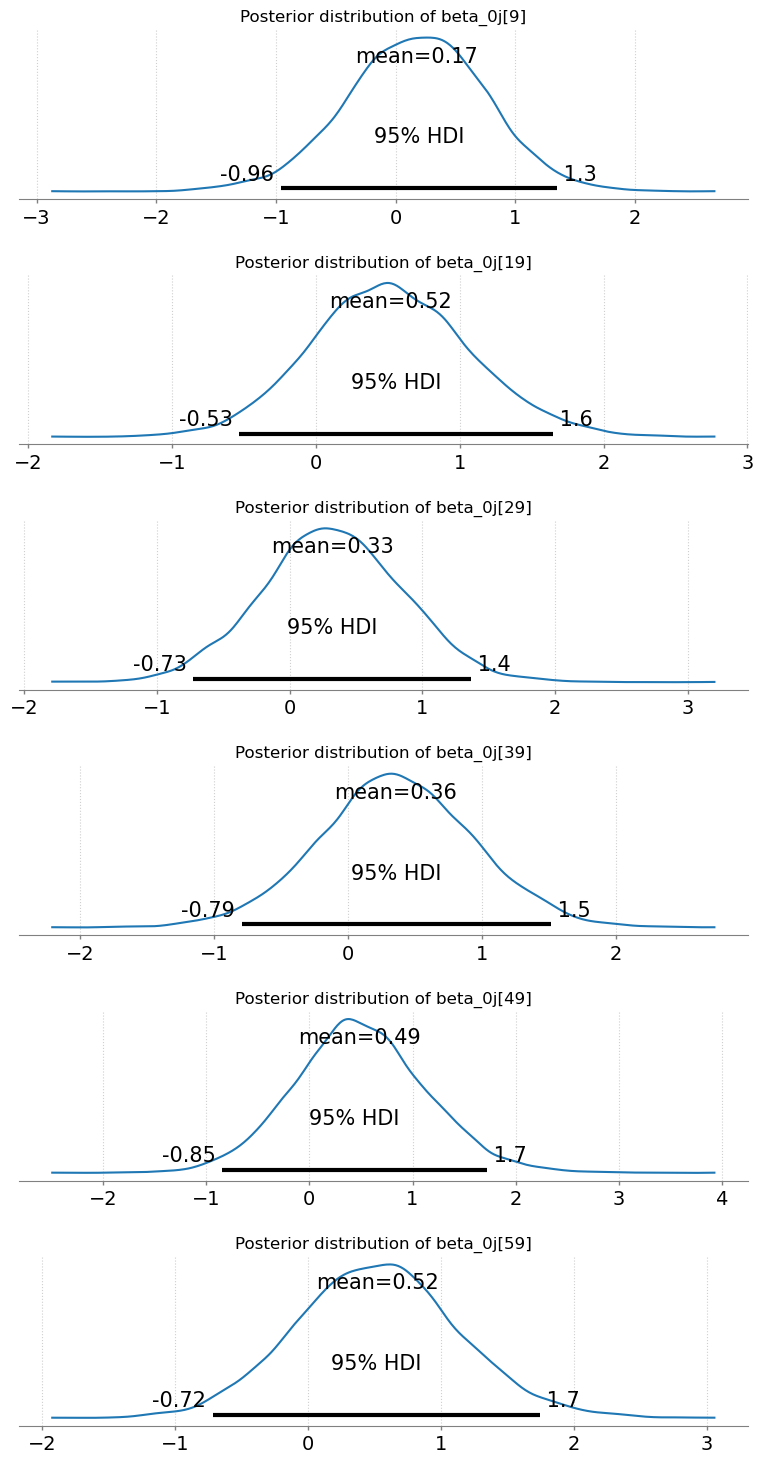

Ellipsis

In [71]:
# your code here

import arviz as az
import matplotlib.pyplot as plt

# Indices of beta_0j to plot
selected_indices = list(range(9, 60, 10))  # [9, 19, 29, ..., 59]

# Extract the corresponding subset from trace.posterior
beta_0j_values = trace.posterior["beta_0j"].sel(beta_0j_dim_0=selected_indices)

# Set up the figure with increased height
fig, axes = plt.subplots(len(selected_indices), 1, figsize=(8, len(selected_indices) * 2.5))

# Ensure correct handling of a single subplot case
if len(selected_indices) == 1:
    axes = [axes]

# Plot posterior distributions
for i, ax in enumerate(axes):
    az.plot_posterior(beta_0j_values[:, :, i], ax=ax, hdi_prob=0.95)
    ax.set_title(f"Posterior distribution of beta_0j[{selected_indices[i]}]", fontsize=12)
    ax.grid(True, linestyle=":", alpha=0.6)  # Light grid for readability

# Adjust layout for better spacing
plt.tight_layout(pad=2.0)  # Increases padding between subplots
plt.show()


...

*Your answer here*

In our plots, the 95% HDIs for each selected district-specific intercept include the corresponding true generating parameter values. This indicates that the model is successfully recovering the true parameters.

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

### <div class='exercise'>Part 2: Varying-Intercept Model (Real Data)</div> 

[Return to contents](#contents)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1 - Fit Varying-Intercept Model (Real Data)</b></div>

Now we'll fit our model to the *actual* data. Construct and fit the varying-intercept model to the real training data.

In [27]:
# your code here
...

df_train["district"] = df_train["district"].astype("category")
district_idx = df_train["district"].cat.codes  # array of integers 0..59
n_districts = df_train["district"].nunique()

# The outcome variable should be 0 or 1
y_obs_real = df_train["contraceptive_use"].values
import pymc as pm

with pm.Model() as varying_intercept_model_real:
    
    # -------------------------
    # Hyperpriors for intercept
    # -------------------------
    mu_0 = pm.Normal("mu_0", mu=0.0, sigma=1.0e4)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)  
    sigma_0 = pm.Deterministic("sigma_0", 1.0 / pm.math.sqrt(tau_0))
    
    # ------------------
    # Varying intercepts
    # ------------------
    # shape=n_districts, e.g. 60
    beta_0j = pm.Normal("beta_0j", mu=mu_0, sigma=sigma_0, shape=n_districts)
    
    # -------------------
    # Other fixed effects
    # -------------------
    beta_1 = pm.Normal("beta_1", mu=0.0, sigma=1.0e4)
    beta_2 = pm.Normal("beta_2", mu=0.0, sigma=1.0e4)
    beta_3 = pm.Normal("beta_3", mu=0.0, sigma=1.0e4)

    # -----------
    # Linear term
    # -----------
    eta = (
        beta_0j[district_idx]
        + beta_1 * df_train["urban"].values
        + beta_2 * df_train["living.children"].values
        + beta_3 * df_train["age_mean"].values
    )

    # -----------
    # Bernoulli likelihood
    # -----------
    p = pm.Deterministic("p", pm.math.sigmoid(eta))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_obs_real)

    # ---------------------
    # Sample from the model
    # ---------------------
    trace_real = pm.sample(
        draws=2000, 
        tune=2000,
        target_accept=0.90,
        random_seed=109
    )

# Summarize posterior samples
pm.summary(
    trace_real, 
    var_names=["mu_0", "sigma_0", "beta_1", "beta_2", "beta_3"],
    kind="stats",  # or kind='all' in newer PyMC versions
    round_to=3
)




Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, beta_0j, beta_1, beta_2, beta_3]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%
mu_0,-1.593,0.247,-2.062,-1.141
sigma_0,0.536,0.110,0.334,0.746
beta_1,0.737,0.164,0.427,1.042
beta_2,0.319,0.080,0.167,0.466
beta_3,-0.035,0.011,-0.055,-0.013


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2 - Convergence Diagnostics</b></div>

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

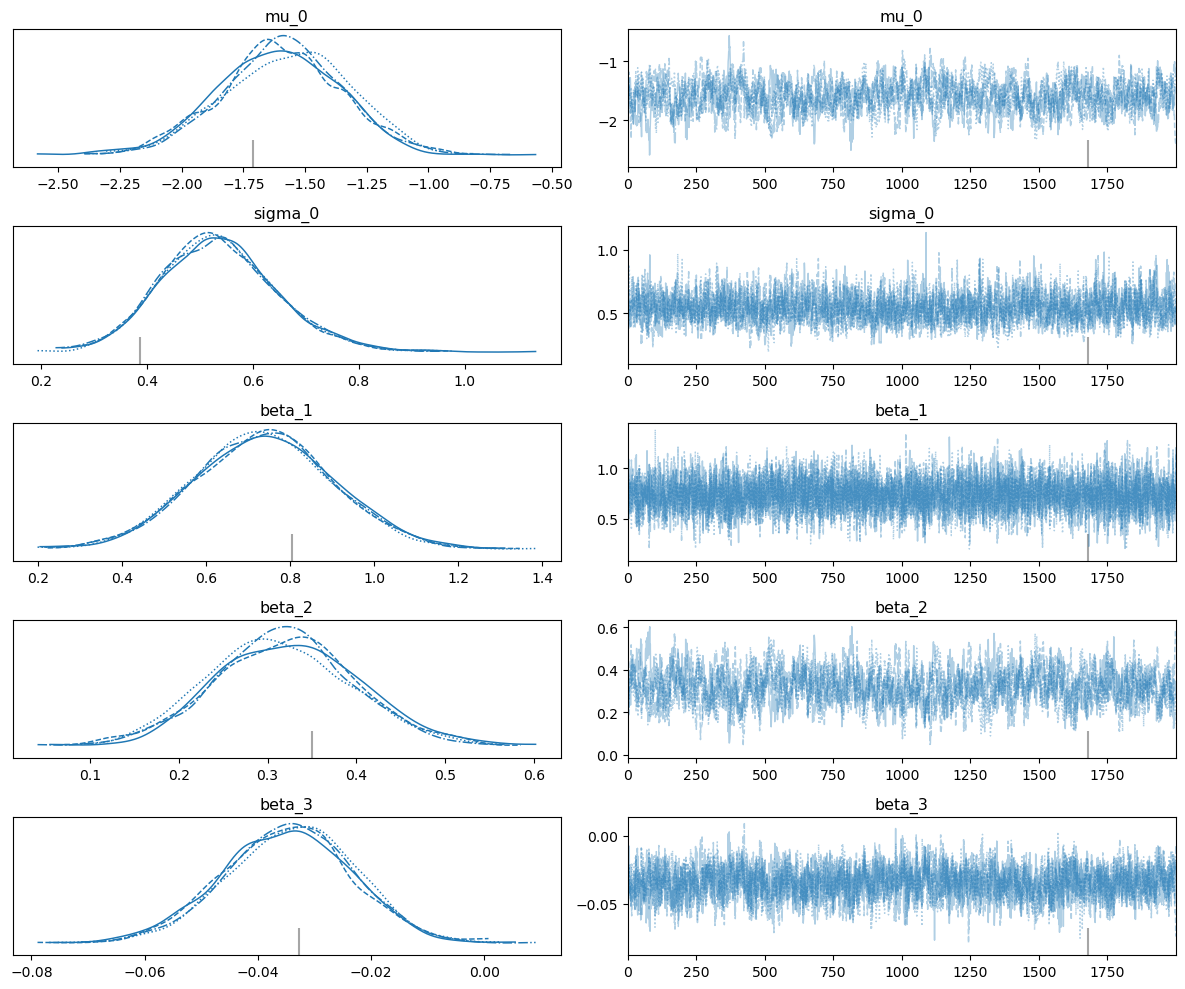

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_0    -1.593  0.247  -2.062   -1.141      0.011    0.008     464.0   
sigma_0  0.536  0.110   0.334    0.746      0.003    0.002    1365.0   
beta_1   0.737  0.164   0.427    1.042      0.002    0.002    4404.0   
beta_2   0.319  0.080   0.167    0.466      0.004    0.003     493.0   
beta_3  -0.035  0.011  -0.055   -0.013      0.000    0.000     913.0   

         ess_tail  r_hat  
mu_0       1278.0    1.0  
sigma_0    2195.0    1.0  
beta_1     5523.0    1.0  
beta_2     1139.0    1.0  
beta_3     2267.0    1.0  


In [30]:
# your code here
...

import matplotlib.pyplot as plt
import pymc as pm

# Plot the trace plots for the key parameters
pm.plot_trace(trace_real, var_names=["mu_0", "sigma_0", "beta_1", "beta_2", "beta_3"])
plt.tight_layout()
plt.show()

# Print a summary including the R-hat statistics
summary = pm.summary(trace_real, var_names=["mu_0", "sigma_0", "beta_1", "beta_2", "beta_3"])
print(summary)


*Your answer here*

The trace plots indicate that the chains for each parameter mix well, and show no signs of sticking; showing that the sampler has successfully converged, and the posterior is reliable.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3 - Districts with Highest & Lowest Rates of Contraceptive Usage</b></div>

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest? Explain how you arrived at these conclusions, interpreting any numerical values that played a role in your reasoning.

In [33]:
# your code here
...

# Access beta_0j from the "posterior" group and compute its mean across chains and draws
beta0j_means = trace_real.posterior["beta_0j"].mean(dim=("chain", "draw")).values

# Convert the log-odds to probabilities using the logistic function
base_rates = 1 / (1 + np.exp(-beta0j_means))

# Identify the district with the highest and lowest base rates
highest_district = np.argmax(base_rates)
lowest_district = np.argmin(base_rates)

print(f"District with the highest base rate: {highest_district} (base rate = {base_rates[highest_district]:.3f})")
print(f"District with the lowest base rate: {lowest_district} (base rate = {base_rates[lowest_district]:.3f})")


District with the highest base rate: 56 (base rate = 0.335)
District with the lowest base rate: 11 (base rate = 0.101)


*Your answer here*

I determined the districts with the highest and lowest base rates of contraceptive usage by first extracting the posterior means of the district-specific intercepts (beta_0j) from our PyMC trace. These intercepts represent the log-odds of contraceptive usage for each district when all other predictors are set to zero. By applying the logistic (inverse logit) transformation to these values, I obtained the base rate (i.e. the probability) for each district.

Based on the code above, the district with the highest base rate (i.e. highest probability) is district index 56 and the district with the lowest base rate is district index 11.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4 - Varying Intercept? Conclusions from Posterior Samples</b></div>

What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts? Explain why or why not.


**Hint:** Both ArviZ's `plot_posterior` and [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) functions will prove useful here.

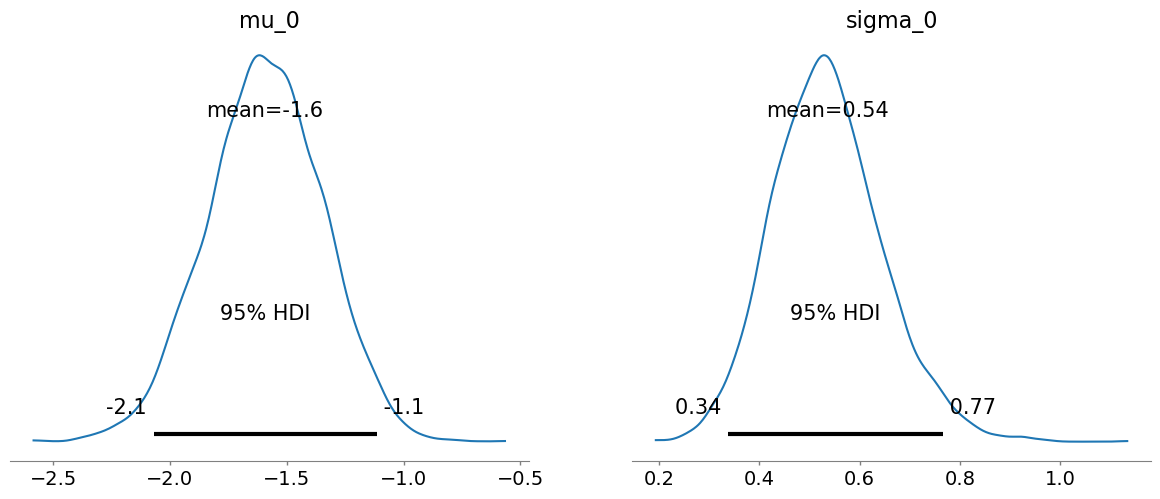

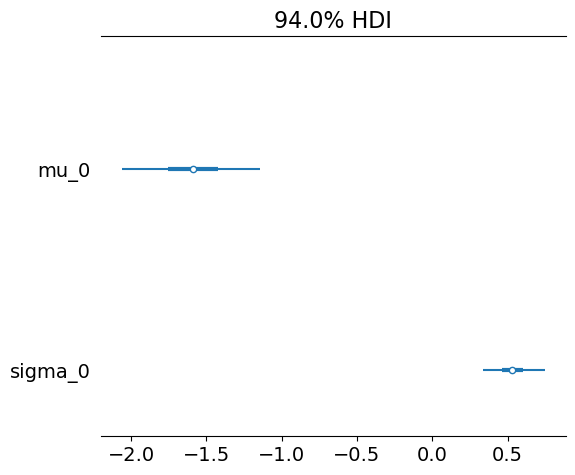

Posterior mean of mu_0: -1.593
Posterior mean of sigma_0: 0.536


In [36]:
# your code here
...



# Plot posterior distributions for mu_0 and sigma_0 using hdi_prob
az.plot_posterior(trace_real, var_names=["mu_0", "sigma_0"], hdi_prob=0.95)
plt.show()

# Alternatively, use a forest plot
az.plot_forest(trace_real, var_names=["mu_0", "sigma_0"], combined=True)
plt.show()

# Compute and print the posterior means for mu_0 and sigma_0
mu0_mean = trace_real.posterior["mu_0"].mean(dim=("chain", "draw")).values.item()
sigma0_mean = trace_real.posterior["sigma_0"].mean(dim=("chain", "draw")).values.item()
print(f"Posterior mean of mu_0: {mu0_mean:.3f}")
print(f"Posterior mean of sigma_0: {sigma0_mean:.3f}")


*Your answer here*

After examining the posterior samples, the posterior mean for \(\mu_0\) is approximately -1.6 and for \(\sigma_0\) is approximately 0.5.

\mu_0 represents the overall average log-odds of contraceptive use across all districts when all predictors are zero.
\sigma_0 represents the extent of variability among the district-specific intercepts.

\(\sigma_0\) indicates that there is meaningful variation in the intercepts across districts. This variability supports the use of a varying-intercept model over a simpler model with a single intercept for all districts.

Thus, the estimated non-zero value for \(\sigma_0\) provides evidence in favor of the varying-intercept model, as it shows that districts differ in their baseline rates of contraceptive use independent of the other covariates.

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 3: Varying-Coefficient Model</div> 

[Return to contents](#contents)


The next model we will fit to the contraceptives data is a **varying-coefficients logistic regression** model. Here, in addition to a varying intercept, the coefficients on `living.children`, `age_mean`, and `urban` also vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:**

* The name "varying coefficient model" is used here to distinguish the Q3 model from the "varying intercept" model in Q2, but observe from the specification about that **BOTH** intercepts *and* coefficients vary in this Q3 model.
* Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 - Fit Varying Coefficient Model</b></div>

Fit the varying-coefficients model described above to the real training data.

In [37]:
# your code here
...

import pymc as pm
import numpy as np
import pandas as pd

# Ensure that 'district' is treated as a categorical variable, so we can index districts as 0,...,J-1.
df_train["district"] = df_train["district"].astype("category")
district_idx = df_train["district"].cat.codes  # integer codes for each district
n_districts = df_train["district"].nunique()

with pm.Model() as varying_coef_model:
    # -------------------------
    # Varying Intercept Component
    # -------------------------
    mu_0 = pm.Normal("mu_0", mu=0, sigma=1e4)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    sigma_0 = pm.Deterministic("sigma_0", 1 / pm.math.sqrt(tau_0))
    beta_0j = pm.Normal("beta_0j", mu=mu_0, sigma=sigma_0, shape=n_districts)
    
    # -------------------------
    # Varying Coefficient for 'urban'
    # -------------------------
    tau_1 = pm.Gamma("tau_1", alpha=0.1, beta=0.1)
    sigma_1 = pm.Deterministic("sigma_1", 1 / pm.math.sqrt(tau_1))
    beta_1j = pm.Normal("beta_1j", mu=0, sigma=sigma_1, shape=n_districts)
    
    # -------------------------
    # Varying Coefficient for 'living.children'
    # -------------------------
    tau_2 = pm.Gamma("tau_2", alpha=0.1, beta=0.1)
    sigma_2 = pm.Deterministic("sigma_2", 1 / pm.math.sqrt(tau_2))
    beta_2j = pm.Normal("beta_2j", mu=0, sigma=sigma_2, shape=n_districts)
    
    # -------------------------
    # Varying Coefficient for 'age_mean'
    # -------------------------
    tau_3 = pm.Gamma("tau_3", alpha=0.1, beta=0.1)
    sigma_3 = pm.Deterministic("sigma_3", 1 / pm.math.sqrt(tau_3))
    beta_3j = pm.Normal("beta_3j", mu=0, sigma=sigma_3, shape=n_districts)
    
    # -------------------------
    # Linear Predictor & Likelihood
    # -------------------------
    # For each observation, select the district-specific parameters using district_idx.
    eta = (
        beta_0j[district_idx] +
        beta_1j[district_idx] * df_train["urban"].values +
        beta_2j[district_idx] * df_train["living.children"].values +
        beta_3j[district_idx] * df_train["age_mean"].values
    )
    
    # Convert log-odds to probability via the logistic function.
    p = pm.Deterministic("p", pm.math.sigmoid(eta))
    
    # Define the likelihood using the Bernoulli distribution.
    y_obs = pm.Bernoulli("y_obs", p=p, observed=df_train["contraceptive_use"].values)
    
    # -------------------------
    # Sample from the Posterior
    # -------------------------
    trace_varying_coef = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        random_seed=109
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, beta_0j, tau_1, beta_1j, tau_2, beta_2j, tau_3, beta_3j]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 21 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2 - Convergence Diagnostics</b></div>

Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the varying-intercept models earlier. What do you observe?

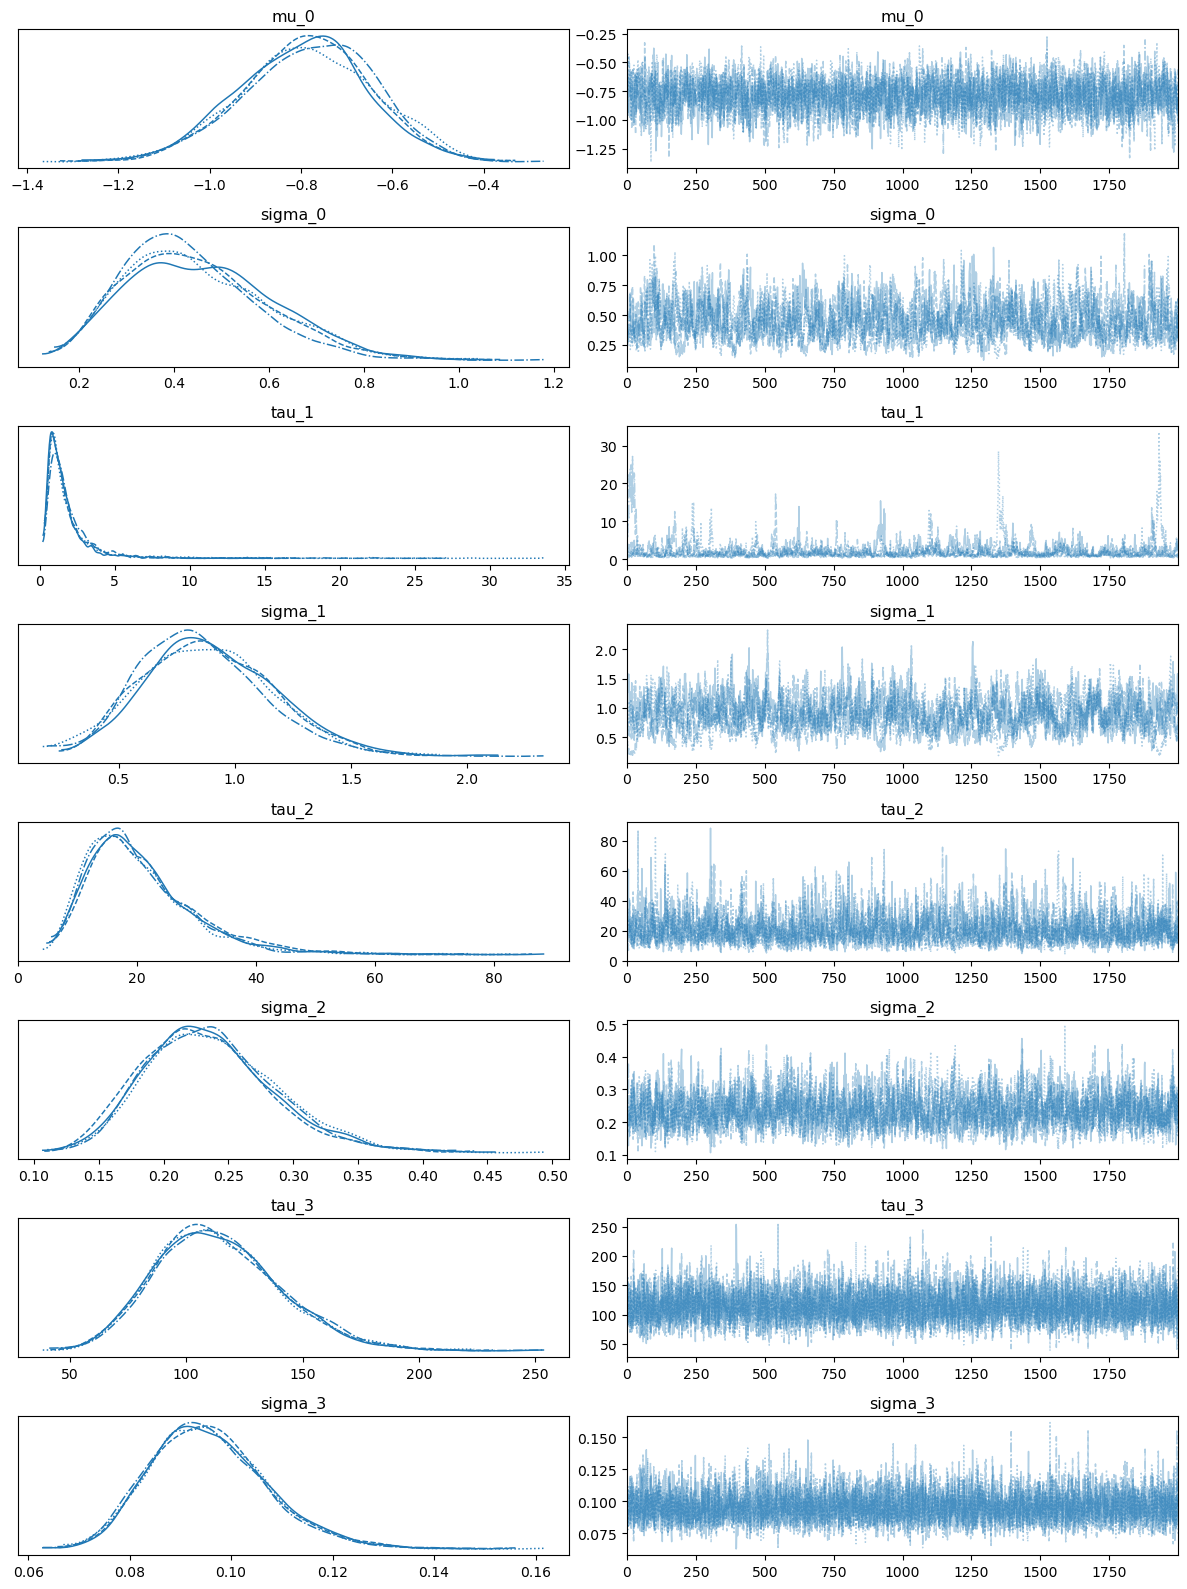

             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_0j[0]  -1.04  0.45   -1.87    -0.17       0.01     0.01   4865.74   
beta_0j[1]  -0.95  0.39   -1.71    -0.23       0.01     0.00   5265.75   
beta_0j[2]  -0.87  0.44   -1.70    -0.02       0.00     0.00   8392.94   
beta_0j[3]  -0.68  0.49   -1.60     0.34       0.01     0.00   7539.26   
beta_0j[4]  -0.68  0.43   -1.48     0.13       0.01     0.00   6213.86   
...           ...   ...     ...      ...        ...      ...       ...   
beta_3j[55] -0.05  0.09   -0.22     0.12       0.00     0.00  13801.47   
beta_3j[56] -0.02  0.05   -0.11     0.06       0.00     0.00   8872.69   
beta_3j[57]  0.04  0.06   -0.08     0.16       0.00     0.00  11433.04   
beta_3j[58]  0.03  0.05   -0.05     0.12       0.00     0.00  13680.39   
beta_3j[59] -0.03  0.07   -0.16     0.10       0.00     0.00  13852.07   

             ess_tail  r_hat  
beta_0j[0]    4181.22    1.0  
beta_0j[1]    4523.21    1.0  
beta_0j[2]    4810

In [38]:
# your code here
...

import arviz as az
import matplotlib.pyplot as plt

# Plot trace plots for key parameters.
# You might choose to plot hyperparameters and a subset of the district-specific coefficients.
az.plot_trace(trace_varying_coef, var_names=["mu_0", "sigma_0", "tau_1", "sigma_1", "tau_2", "sigma_2", "tau_3", "sigma_3"])
plt.tight_layout()
plt.show()

# Obtain a summary including R-hat values for district-specific coefficients.
summary_varying_coef = az.summary(
    trace_varying_coef, 
    var_names=["beta_0j", "beta_1j", "beta_2j", "beta_3j"],
    round_to=2
)
print(summary_varying_coef)


*Your answer here*

Based on the trace plots for the varying-coefficient model, the chains for all key parameters (the district-specific slopes, and intercepts) appear to mix well. There are no clear trends or drifting in the chains over iterations—they overlap nicely, indicating that the sampler has reached a stationary distribution. Together, these diagnostics provide good evidence that the sampler has converged and that the posterior estimates are reliable.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3 - Distribution of Posterior Means & HDIs</b></div>

Plot the distributions of posterior means and the 95% highest posterior density intervals (HDIs) for the intercepts and coefficients for each district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

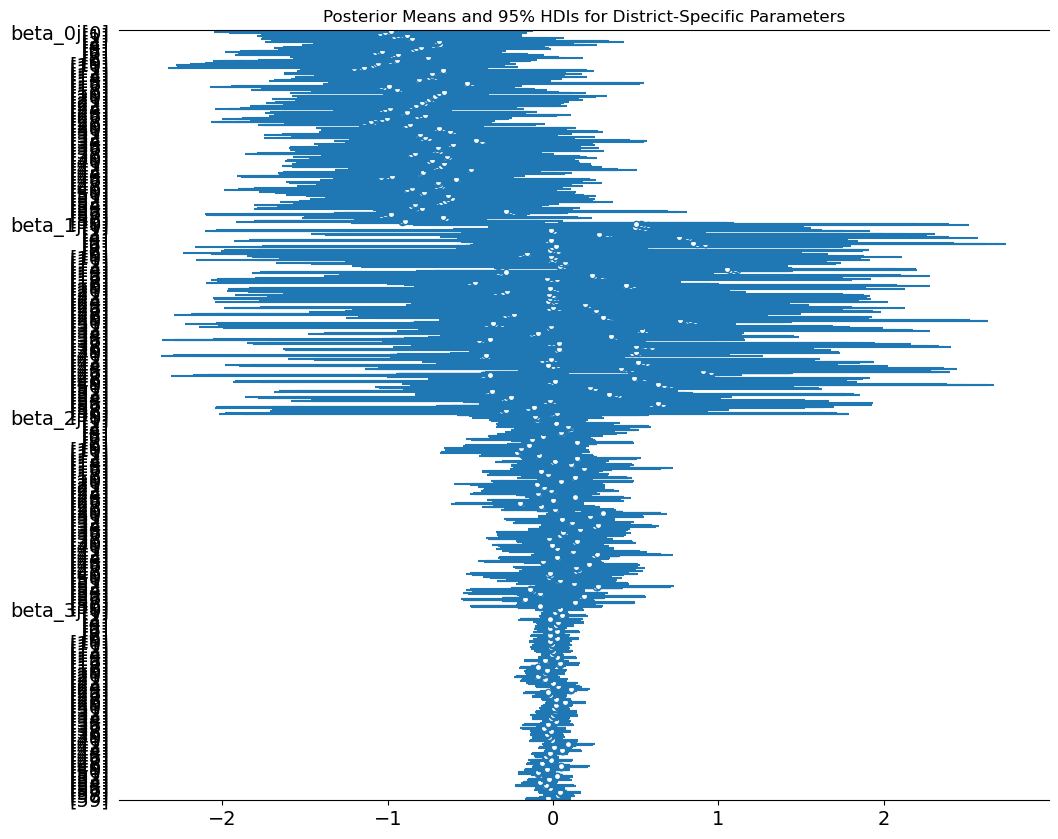

In [42]:
# your code here
...

import arviz as az
import matplotlib.pyplot as plt

# Plot the posterior means and 95% HDIs for district-specific intercepts and coefficients.
az.plot_forest(
    trace_varying_coef,
    var_names=["beta_0j", "beta_1j", "beta_2j", "beta_3j"],
    combined=False,
    hdi_prob=0.95,
    figsize=(12, 10)
)

plt.title("Posterior Means and 95% HDIs for District-Specific Parameters")
plt.show()


*Your answer here*

The forest plots display the posterior means and the 95% HDIs for the district-specific intercepts and coefficients. The posterior means for the intercepts and coefficients vary noticeably across districts. This indicates that the effect of predictors on contraceptive use is not uniform and that there is substantial heterogeneity between districts. The width of the 95% HDIs varies among districts. For some districts, the intervals are narrow—suggesting high confidence in the estimates—while for others they are wider, indicating more uncertainty.

These plots provide strong evidence that both the baseline rates (intercepts) and the effects of predictors differ by district. This justifies the use of a varying-coefficient model, as it captures these district-level differences more accurately than a model with constant effects would.




<a id="part4"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 4: Predictions & Model Selection</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1 - Model Evaluation & Comparison</b></div>

Now that we’ve fit varying-intercept and varying-coefficient models we will evaluate their predictive performance and compare them to a naive baseline.
 
First, sample from the posterior predictive distribution using `pm.sample_posterior_predictive()`, generating predictions for both models on the train and test sets.

Next, compute the accuracy and percentage of predictions classified as `1` for each model on both train and test.

Finally, compute the train and test accuracy of a naive model that predicts the most common class in the training set for all inputs.

In [69]:
# your code here
...


import numpy as np
import pandas as pd
import pymc as pm
import arviz as az


df_train = pd.read_csv("data/train.csv")
df_test  = pd.read_csv("data/test.csv")


df_train["district"] = df_train["district"].astype("category")
df_test["district"] = pd.Categorical(df_test["district"], categories=df_train["district"].cat.categories)

y_train = df_train["contraceptive_use"].values
y_test  = df_test["contraceptive_use"].values


with pm.Model() as varying_intercept_model:
    # Define shared data variables
    district_idx = pm.Data("district_idx", df_train["district"].cat.codes.values)
    urban = pm.Data("urban", df_train["urban"].values)
    living_children = pm.Data("living_children", df_train["living.children"].values)
    age_mean = pm.Data("age_mean", df_train["age_mean"].values)
    
    # Priors for hyperparameters and coefficients
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    sigma_0 = pm.Deterministic("sigma_0", 1 / pm.math.sqrt(tau_0))
    
    beta_0j = pm.Normal("beta_0j", mu=mu_0, sigma=sigma_0, shape=df_train["district"].nunique())
    beta_1 = pm.Normal("beta_1", mu=0, sigma=100)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=100)
    beta_3 = pm.Normal("beta_3", mu=0, sigma=100)
    
    # Linear predictor and likelihood
    logit_p = beta_0j[district_idx] + beta_1 * urban + beta_2 * living_children + beta_3 * age_mean
    p = pm.math.sigmoid(logit_p)
    Y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)
    
    # Sample from the posterior
    trace_vi = pm.sample(draws=2000, tune=2000, target_accept=0.9, random_seed=109)

with pm.Model() as varying_coef_model:

    district_idx = pm.Data("district_idx", df_train["district"].cat.codes.values)
    urban = pm.Data("urban", df_train["urban"].values)
    living_children = pm.Data("living_children", df_train["living.children"].values)
    age_mean = pm.Data("age_mean", df_train["age_mean"].values)
    
    n_districts = df_train["district"].nunique()
    
    # Hyperpriors for the intercept
    mu_0 = pm.Normal("mu_0", mu=0, sigma=1e4)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    sigma_0 = pm.Deterministic("sigma_0", 1 / pm.math.sqrt(tau_0))
    beta_0j = pm.Normal("beta_0j", mu=mu_0, sigma=sigma_0, shape=n_districts)
    
    # Hyperpriors and district-specific slopes for each predictor:
    tau_1 = pm.Gamma("tau_1", alpha=0.1, beta=0.1)
    sigma_1 = pm.Deterministic("sigma_1", 1 / pm.math.sqrt(tau_1))
    beta_1j = pm.Normal("beta_1j", mu=0, sigma=sigma_1, shape=n_districts)
    
    tau_2 = pm.Gamma("tau_2", alpha=0.1, beta=0.1)
    sigma_2 = pm.Deterministic("sigma_2", 1 / pm.math.sqrt(tau_2))
    beta_2j = pm.Normal("beta_2j", mu=0, sigma=sigma_2, shape=n_districts)
    
    tau_3 = pm.Gamma("tau_3", alpha=0.1, beta=0.1)
    sigma_3 = pm.Deterministic("sigma_3", 1 / pm.math.sqrt(tau_3))
    beta_3j = pm.Normal("beta_3j", mu=0, sigma=sigma_3, shape=n_districts)
    
    # Linear predictor and likelihood
    logit_p = (beta_0j[district_idx] +
               beta_1j[district_idx] * urban +
               beta_2j[district_idx] * living_children +
               beta_3j[district_idx] * age_mean)
    p = pm.math.sigmoid(logit_p)
    Y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)
    
    # Sample from the posterior
    trace_vc = pm.sample(draws=2000, tune=2000, target_accept=0.9, random_seed=109)

def compute_metrics(ppc, true_y):
    """
    ppc: InferenceData from pm.sample_posterior_predictive (predictions stored as "y_obs")
    true_y: true outcome array
    """
    # Extract predictions: shape (chain, draw, n_samples)
    y_samples = ppc.posterior_predictive["y_obs"].values
    # Average predictions over chains and draws to get per-observation probability
    pred_prob = y_samples.mean(axis=(0, 1))
    preds = (pred_prob >= 0.5).astype(int)
    accuracy = (preds == true_y).mean()
    frac_ones = preds.mean()
    return accuracy, frac_ones

train_data = {
    "district_idx": df_train["district"].cat.codes.values,
    "urban": df_train["urban"].values,
    "living_children": df_train["living.children"].values,
    "age_mean": df_train["age_mean"].values,
}
test_data = {
    "district_idx": df_test["district"].cat.codes.values,
    "urban": df_test["urban"].values,
    "living_children": df_test["living.children"].values,
    "age_mean": df_test["age_mean"].values,
}

with varying_intercept_model:
    pm.set_data(train_data)
    ppc_train_vi = pm.sample_posterior_predictive(trace_vi, random_seed=109)
    acc_train_vi, frac_train_vi = compute_metrics(ppc_train_vi, y_train)
    
    pm.set_data(test_data)
    ppc_test_vi = pm.sample_posterior_predictive(trace_vi, random_seed=109)
    acc_test_vi, frac_test_vi = compute_metrics(ppc_test_vi, y_test)

# Varying-Coefficient Model Predictions
with varying_coef_model:
    pm.set_data(train_data)
    ppc_train_vc = pm.sample_posterior_predictive(trace_vc, random_seed=109)
    acc_train_vc, frac_train_vc = compute_metrics(ppc_train_vc, y_train)
    
    pm.set_data(test_data)
    ppc_test_vc = pm.sample_posterior_predictive(trace_vc, random_seed=109)
    acc_test_vc, frac_test_vc = compute_metrics(ppc_test_vc, y_test)

# Naive Baseline: Always predict the majority class from training data
majority_class = pd.Series(y_train).mode()[0]
acc_train_naive = (np.full_like(y_train, majority_class) == y_train).mean()
acc_test_naive  = (np.full_like(y_test, majority_class) == y_test).mean()

print("==== Model Evaluation & Comparison ====")
print("Varying-Intercept Model:")
print(f"  Train Accuracy: {acc_train_vi:.3f}, % Ones: {frac_train_vi:.3f}")
print(f"  Test  Accuracy: {acc_test_vi:.3f}, % Ones: {frac_test_vi:.3f}\n")

print("Varying-Coefficient Model:")
print(f"  Train Accuracy: {acc_train_vc:.3f}, % Ones: {frac_train_vc:.3f}")
print(f"  Test  Accuracy: {acc_test_vc:.3f}, % Ones: {frac_test_vc:.3f}\n")

print("Naive Baseline (predict majority class =", majority_class, "):")
print(f"  Train Accuracy: {acc_train_naive:.3f}")
print(f"  Test  Accuracy: {acc_test_naive:.3f}")



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, beta_0j, beta_1, beta_2, beta_3]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, beta_0j, tau_1, beta_1j, tau_2, beta_2j, tau_3, beta_3j]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Sampling: [y_obs]


Output()

Sampling: [y_obs]


Output()

Sampling: [y_obs]


Output()

==== Model Evaluation & Comparison ====
Varying-Intercept Model:
  Train Accuracy: 0.672, % Ones: 0.219
  Test  Accuracy: 0.654, % Ones: 0.202

Varying-Coefficient Model:
  Train Accuracy: 0.698, % Ones: 0.266
  Test  Accuracy: 0.620, % Ones: 0.264

Naive Baseline (predict majority class = 0 ):
  Train Accuracy: 0.610
  Test  Accuracy: 0.605


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2 - Model Selection</b></div>

What do you conclude from the results of 4.1? Which model appears to be the best (i.e. varying-intercept, varying-coefficient, or naive), and what is your rationale?

*Your answer here*

Based on the evaluation metrics from Q4.1:

The naive model (which always predicts the majority class) performs the worst, with both train and test accuracies around 61%. The varying‐intercept model achieves moderate performance, with about 67% accuracy on the training set and 65% on the test set. The varying‐coefficient model shows a slightly higher training accuracy (around 70%) but a lower test accuracy (about 62%), suggesting it may be overfitting the training data.

Thus, the varying‐intercept model appears to be the best because it strikes a better balance between fitting the training data and generalizing to unseen test data. Its higher test accuracy compared to both the naive baseline and the varying‐coefficient model indicates that capturing district-level baseline differences is sufficient for this task without the additional complexity (and potential overfitting) introduced by varying the predictor effects across districts.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `time_spent_on_hw`

In [43]:
time_spent_on_hw = 5

*Your answer here*

I found debugging and figuring out what plots are reasonable or unreasonable to be the most difficult. 

In [44]:
grader.check("q4.3")

q4.3 results: All test cases passed!

In [45]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 1081.84 minutes for this notebook to run


**This concludes HW1. Thank you!** 🌈